**Detection of Lung Diseases Using ResNet50**



*  Using ResNet50 for pulmonary disease detection generally involves a process of transfer learning and fine-tuning to leverage the capabilities of this pre-trained model and achieve accurate results in classifying chest X-ray images.



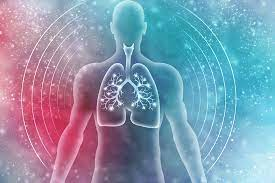

---



In [ ]:

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import opendatasets as od
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50V2
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, utils, callbacks
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import (ImageDataGenerator,
                                                  load_img, img_to_array)
from sklearn.metrics import (classification_report, accuracy_score,precision_score,
                             recall_score,confusion_matrix,roc_curve,roc_auc_score,
                             confusion_matrix)
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

**Importing the dataset directly from Kaggle**

1.   Élément de liste
2.   Élément de liste



This dataset mainly consists of the chest X-ray images of Normal and Pneumonia affected patients. There is a total of 5840 chest X-ray images. It has two folders named train and test. Each of them has two sub-folders labeled as NORMAL and PNEUMONIA. This dataset can be used to detect pneumonia by training ResNet50 Model.

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"samarjelassi","key":"e579deefeb221f4e4da9e7d07bf158be"}'}

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od

# Download data from Kaggle using my API key
od.download("https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia")

100%|██████████| 2.29G/2.29G [00:20<00:00, 123MB/s]


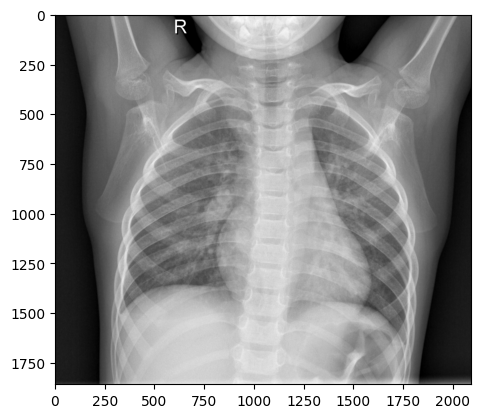

In [ ]:
# Test plot images
img=cv2.imread('./chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
img2 = img[:,:,::-1]
plt.imshow(img2)

In [ ]:
train_path = './chest-xray-pneumonia/chest_xray/train'
valid_path = './chest-xray-pneumonia/chest_xray/test'

In [ ]:
resnet = ResNet50(input_shape = (224,224,3) ,weights = 'imagenet',include_top = False)

* ResNet50 is a convolutional neural network architecture introduced by Microsoft
Research in 2015. It is part of the ResNet (Residual Network) family, known for its depth and efficient training methodologies.

* ResNet50 specifically refers to a Residual Network with 50 layers, including convolutional layers, pooling layers, fully connected layers, and skip connections. The key innovation of ResNet is the use of residual blocks, which enable the network to be significantly deeper while overcoming the vanishing gradient problem encountered in very deep networks.


* ResNet50 has been pretrained on a large dataset (e.g., ImageNet) and has shown excellent performance in various computer vision tasks, including image classification, object detection, and feature extraction. Due to its depth and learned features, it's often used as a feature extractor or as a base model for transfer learning in various image-related tasks.

In [ ]:
for layer in resnet.layers[:15]:
    layer.trainable = False

for i, layer in enumerate(resnet.layers):
    print(i, layer.name, layer.trainable)

0 input_3 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_bl

In [ ]:
x = resnet.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dense(2, activation='softmax')(x) # Softmax for multiclass
model = Model(inputs=resnet.input, outputs=x)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [ ]:
# Use the Image Data Generator to import the images from the dataset
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('./chest-xray-pneumonia/chest_xray/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 5216 images belonging to 2 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('./chest-xray-pneumonia/chest_xray/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 624 images belonging to 2 classes.


In [72]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

<ipython-input-72-dcaa1ca38143>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/20
163/163 [==============================] - 169s 793ms/step - loss: 0.8292 - accuracy: 0.8474 - val_loss: 1628173.7500 - val_accuracy: 0.6250
Epoch 2/20
163/163 [==============================] - 125s 766ms/step - loss: 0.2821 - accuracy: 0.8986 - val_loss: 11986.3428 - val_accuracy: 0.6250
Epoch 3/20
163/163 [==============================] - 136s 833ms/step - loss: 0.1998 - accuracy: 0.9220 - val_loss: 0.7606 - val_accuracy: 0.6250
Epoch 4/20
163/163 [==============================] - 130s 798ms/step - loss: 0.1968 - accuracy: 0.9287 - val_loss: 1.7064 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 132s 807ms/step - loss: 0.1481 - accuracy: 0.9454 - val_loss: 0.6186 - val_accuracy: 0.7163
Epoch 6/20
163/163 [==============================] - 132s 804ms/step - loss: 0.1332 - accuracy: 0.9534 - val_loss: 0.5153 - val_accuracy: 0.7853
Epoch 7/20
163/163 [==============================] - 124s 759ms/step - loss: 0.1409 - accuracy: 0.9513 - val_loss

**Conclusion:**
Les résultats affichent l'évolution de l'entraînement d'un modèle sur 20 epochs.

Perte (Loss) : La perte diminue généralement au fil des epochs, ce qui indique que le modèle apprend progressivement à réduire les erreurs lors de l'entraînement.

Exactitude (Accuracy) : L'exactitude augmente globalement, montrant que le modèle devient meilleur pour prédire les bonnes étiquettes pour les données d'entraînement.

Overfitting : Il semble y avoir des signes de surapprentissage (overfitting) car l'exactitude des données d'entraînement (training accuracy) est bien supérieure à celle des données de validation (validation accuracy) à partir de l'epoch 8. Cela peut indiquer que le modèle commence à trop s'adapter aux données spécifiques d'entraînement et ne généralise pas bien sur de nouvelles données.

Stabilité des performances : À partir de l'epoch 13, la perte et l'exactitude sur les données de validation semblent se stabiliser, ce qui peut indiquer que le modèle n'apprend plus significativement après cet epoch.

**Perspectives:**

Pour améliorer davantage ces résultats:

- Réduire l'overfitting : Envisager des approches de régularisation comme l'application de couches Dropout ou l'utilisation de la régularisation L2, ainsi que la simplification du modèle ou l'adoption de techniques d'augmentation de données pour renforcer sa généralisation.

- Appliquer des méthodes de réglage hyperparamétrique : Établir les hyperparamètres optimaux pour le modèle, par exemple, ajuster le taux d'apprentissage, la profondeur des couches, etc., à travers des itérations itératives.